In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline 

In [3]:
import os
from glob import glob
import itertools
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn import utils
import xgboost as xgb
import matplotlib
import pickle
import copy

## Configuration

### Plotting styling

In [4]:
colors = {}
colors['Threshold0'] = 'black'
colors['Threshold'] = 'black'
colors['Mixedbcstc'] = 'black'
colors['AutoEncoderTelescopeMSE'] = 'tab:blue'
colors['AutoEncoderStride'] = 'tab:orange'
colors['AutoEncoderQKerasTTbar'] = 'tab:red'
colors['AutoEncoderQKerasEle'] = 'tab:green'


styles = {}
styles['Threshold0'] = '-'
styles['Threshold'] = '-.'
styles['Mixedbcstc'] = '--'
styles['AutoEncoderTelescopeMSE'] = '-'
styles['AutoEncoderStride'] = '-'
styles['AutoEncoderQKerasTTbar'] = '--'
styles['AutoEncoderQKerasEle'] = '--'

markers = {}
markers['Threshold0'] = 'o'
markers['Threshold'] = 'o'
markers['Mixedbcstc'] = 'o'
markers['AutoEncoderTelescopeMSE'] = 'o'
markers['AutoEncoderStride'] = 'o'
markers['AutoEncoderQKerasTTbar'] = 'o'
markers['AutoEncoderQKerasEle'] = 'o'



legends = {}
legends['Threshold0'] = 'All TC'
legends['Threshold'] = 'Threshold 1.35 mipT'
legends['Mixedbcstc'] = 'BC+STC'
legends['AutoEncoderTelescopeMSE'] = 'AE Telescope MSE'
legends['AutoEncoderStride'] = 'AE Stride'
legends['AutoEncoderQKerasTTbar'] = 'AE QKeras ttbar'
legends['AutoEncoderQKerasEle'] = 'AE QKeras Ele'

ref_name = 'Threshold0'
plotted_algo = ['Threshold0',
                'Threshold',
                'Mixedbcstc',
                'AutoEncoderTelescopeMSE', 
                'AutoEncoderStride',
                'AutoEncoderQKerasTTbar',
                'AutoEncoderQKerasEle',
               ]

### Input files and FE algorithms to be studied

200 PU electrons and pure 200PU events are loaded

In [5]:
version = '210611'
fig_dir = '../img/electron_pu_autoencoder_{}'.format(version)
algo_files = {}
# Read signal driven files
directory_elec = '/Users/cmantill/ECON/ASIC/ECONAutoencoderStudy/notebooks/data/3_22_1/electron_photon_signaldriven/v_1_2021-06-20'
directory_pu = '/Users/cmantill/ECON/ASIC/ECONAutoencoderStudy/notebooks/data/3_22_1/pu_for_id_signaldriven/v_1_2021-06-20/MinBias/'
fes = ['Threshold0', 'Threshold', 'Mixedbcstc',
       'AutoEncoderTelescopeMSE', 'AutoEncoderStride',
       'AutoEncoderQKerasTTbar', 'AutoEncoderQKerasEle',]
for fe in fes:
    algo_files[fe] = (glob(directory_elec+'/electrons/*.hdf5'), glob(directory_pu+'/*.hdf5'))

## Loading and preprocessing dataframes
Selection cuts (in addition to those already applied before):
- Gen electron $15 < p_T < 150 GeV$
- Extrapolated gen electron eta between 1.6 and 2.9
- PU cluster eta between 1.6 and 2.9

Additionally label electrons and positrons as `1` and PU clusters as `0`

In [6]:
ptmin=15
ptmax=150
etamin=1.6
etamax=2.9
algos_dfs = {}

for fe,files in algo_files.items():
    name = fe
    dfs = []
    for file in files[0]:
        store = pd.HDFStore(file, mode='r')
        df = store[name]
        store.close()
        sel = df['genpart_pt']>ptmin
        df = df[sel]
        sel = df['genpart_pt']<ptmax
        df = df[sel]
        sel = np.abs(df['genpart_exeta'])>etamin
        df = df[sel]
        sel = np.abs(df['genpart_exeta'])<etamax
        df = df[sel]
        sel = df['matches']==True
        df = df[sel]
        df['genpart_pid'].replace([-11,11],1, inplace=True)
        dfs.append(df)
    for file in files[1]:
        store = pd.HDFStore(file, mode='r')
        df = store[fe]
        store.close()
        df['genpart_pid'] = 0
        sel = np.abs(df['cl3d_eta'])>etamin
        df = df[sel]
        sel = np.abs(df['cl3d_eta'])<etamax
        df = df[sel]
        dfs.append(df)
    algos_dfs[fe] = pd.concat(dfs)


Retrieve the number of PU clusters per event. 

The number of events stored in the dataframe is not the total number of events since preselection cuts are applied. The total number of events kept during the preprocessing is retrieved in order to compute the number of clusters per event.

In [7]:
# Compute the average number of clusters per event stored in the dataframe
nclusters_per_event = {}
for fe,df in algos_dfs.items():
    df_pu = df[df.genpart_pid==0]
    clusters_per_event = df_pu.groupby('event').count()
    nclusters_per_event[fe] = np.mean(clusters_per_event.genpart_pid)
    
# Retrieve the total number of events before preselection
events_pu = {}
for fe,files in algo_files.items():
    evts = 0
    for file in files[1]:
        with open(os.path.splitext(file)[0]+'.txt', 'r') as f:
            lines = f.readlines()
            evts += int(lines[0])
        events_pu[fe] = evts
        
# Compute the number of events in the dataframe
events_pu_stored = {}
for fe,df in algos_dfs.items():
    df_pu = df[df.genpart_pid==0]
    events = np.unique(df_pu.reset_index()['event']).shape[0]
    events_pu_stored[fe] = events

# Correct the number of clusters / event based on the total number of events
for fe, nclusters in nclusters_per_event.items():
    nclusters_per_event[fe] = nclusters*events_pu_stored[fe]/events_pu[fe]
    print(fe, nclusters_per_event[fe], 'clusters / event')

Threshold0 0.02432875098916064 clusters / event
Threshold 0.019875227736984486 clusters / event
Mixedbcstc 0.027880527797714348 clusters / event
AutoEncoderTelescopeMSE 0.015734555291779386 clusters / event
AutoEncoderStride 0.01645227184894827 clusters / event
AutoEncoderQKerasTTbar 0.01498003275731979 clusters / event
AutoEncoderQKerasEle 0.01580816724636081 clusters / event


In [8]:
for fe,df in algos_dfs.items():
    print(fe, '\n > background =', df[df.genpart_pid==0].shape[0], 'signal =', df[df.genpart_pid==1].shape[0])

Threshold0 
 > background = 1322 signal = 138773
Threshold 
 > background = 1080 signal = 138772
Mixedbcstc 
 > background = 1515 signal = 138769
AutoEncoderTelescopeMSE 
 > background = 855 signal = 138766
AutoEncoderStride 
 > background = 894 signal = 138760
AutoEncoderQKerasTTbar 
 > background = 814 signal = 138763
AutoEncoderQKerasEle 
 > background = 859 signal = 138760


In [9]:
for name,df in algos_dfs.items():
    df['cl3d_abseta'] = np.abs(df.cl3d_eta)

Check cluster eta and pT distributions. Note that this is the uncorrected pT that is plotted.

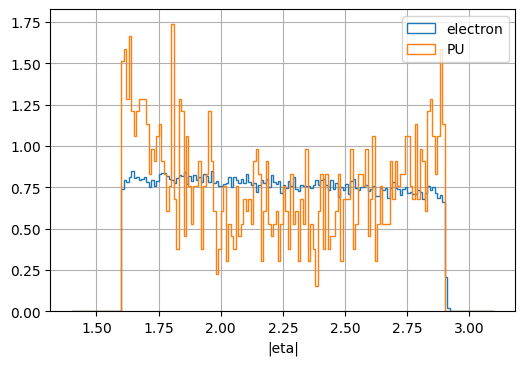

In [10]:
plt.figure(dpi=100)
plt.hist(algos_dfs['Threshold0'].query('genpart_pid==1').cl3d_abseta, 
         histtype='step', density=True, bins=np.arange(1.4, 3.1, 0.01),
         label='electron')
plt.hist(algos_dfs['Threshold0'].query('genpart_pid==0').cl3d_abseta,
         histtype='step', density=True, bins=np.arange(1.4, 3.1, 0.01),
         label='PU')
plt.grid()
plt.legend()
plt.xlabel('|eta|')
plt.show()

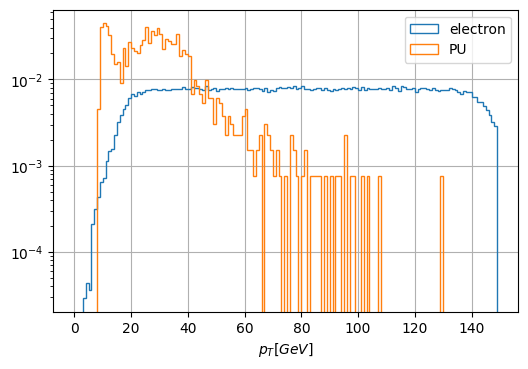

In [11]:
plt.figure(dpi=100)
plt.hist(algos_dfs['Threshold0'].query('genpart_pid==1').cl3d_pt, 
         histtype='step', density=True, bins=np.arange(0, 150, 1),
         label='electron')
plt.hist(algos_dfs['Threshold0'].query('genpart_pid==0').cl3d_pt,
         histtype='step', density=True, bins=np.arange(0, 150, 1),
         label='PU')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xlabel(r'$p_T [GeV]$')
plt.show()

## BDT training

In [12]:

def train_xgb(df, inputs, output, hyperparams):
    X, y  = utils.shuffle(df[inputs], df[output], random_state=1234)
    weight_elec = y[y==0].shape[0]/y[y==1].shape[0]
    w_train = np.where(y==1, weight_elec, 1.)
    print("  > Electron size:", y[y==1].shape[0])
    print("  > PU size:", y[y==0].shape[0])
    print("  > Applying weight of", weight_elec, "to electrons to balance the sample")
    # The full sample is used for training
    train = xgb.DMatrix(data=X,label=y, weight=w_train, feature_names=inputs)
    test = xgb.DMatrix(data=df[inputs],label=df[output], feature_names=inputs)
    params_cp = copy.deepcopy(hyperparams)
    params_cp.pop('n_estimators')
    booster = xgb.train(params_cp, train, num_boost_round=hyperparams['n_estimators'])
    df['bdt_output'] = booster.predict(test)
    fpr, tpr, threshold = metrics.roc_curve(df[output], df['bdt_output'])
    return booster, fpr, tpr, threshold

def train_all(name_dfs, inputs, output, hyperparams):
    boosters = {}
    fprs = {}
    tprs = {}
    thresholds = {}
    for name,df in name_dfs.items():
        print(' FE algorithm', name)
        boosters[name], fprs[name], tprs[name], thresholds[name] = train_xgb(df, inputs, output, hyperparams)
    return boosters, fprs, tprs, thresholds


In [13]:
inputs ={
    'extended':['cl3d_abseta','cl3d_showerlength',
    'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_szz',
    'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean',
    'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10',
    'cl3d_layer50', 'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90'],
}
output = 'genpart_pid'

param = {}
param['nthread'] = 5  # limit number of threads to 5
param['learning_rate'] = 0.05 # initial learning rate
param['max_depth'] = 4  # maximum depth of a tree
param['lambda'] = 10 # L2 regularization
param['alpha'] = 10 # L1 regularization
param['n_estimators'] = 50 
param['subsample'] = 0.8 # fraction of events to train tree on
param['colsample_bytree'] = 0.8 # fraction of features to train tree on
param['objective'] = 'binary:logistic'

boosters = {}
fprs = {}
tprs = {}
thresholds = {}
for name, features in inputs.items():
    print('Training with feature set "', name, '"')
    boosters[name], fprs[name], tprs[name], thresholds[name] = train_all(algos_dfs, features, output, param)

Training with feature set " extended "
 FE algorithm Threshold0
  > Electron size: 138773
  > PU size: 1322
  > Applying weight of 0.00952634878542656 to electrons to balance the sample
[12:53:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 FE algorithm Threshold
  > Electron size: 138772
  > PU size: 1080
  > Applying weight of 0.007782549793906551 to electrons to balance the sample
[12:53:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 FE algorithm Mixedbcstc
  > Electron size: 138769
  > PU size: 1515
  > Applying weight of 0.010917423

### Background efficiency vs signal efficiency

Note that ROC curves are not directly comparable because the population of initial (reconstructed) PU clusters and their number differ between algorithms

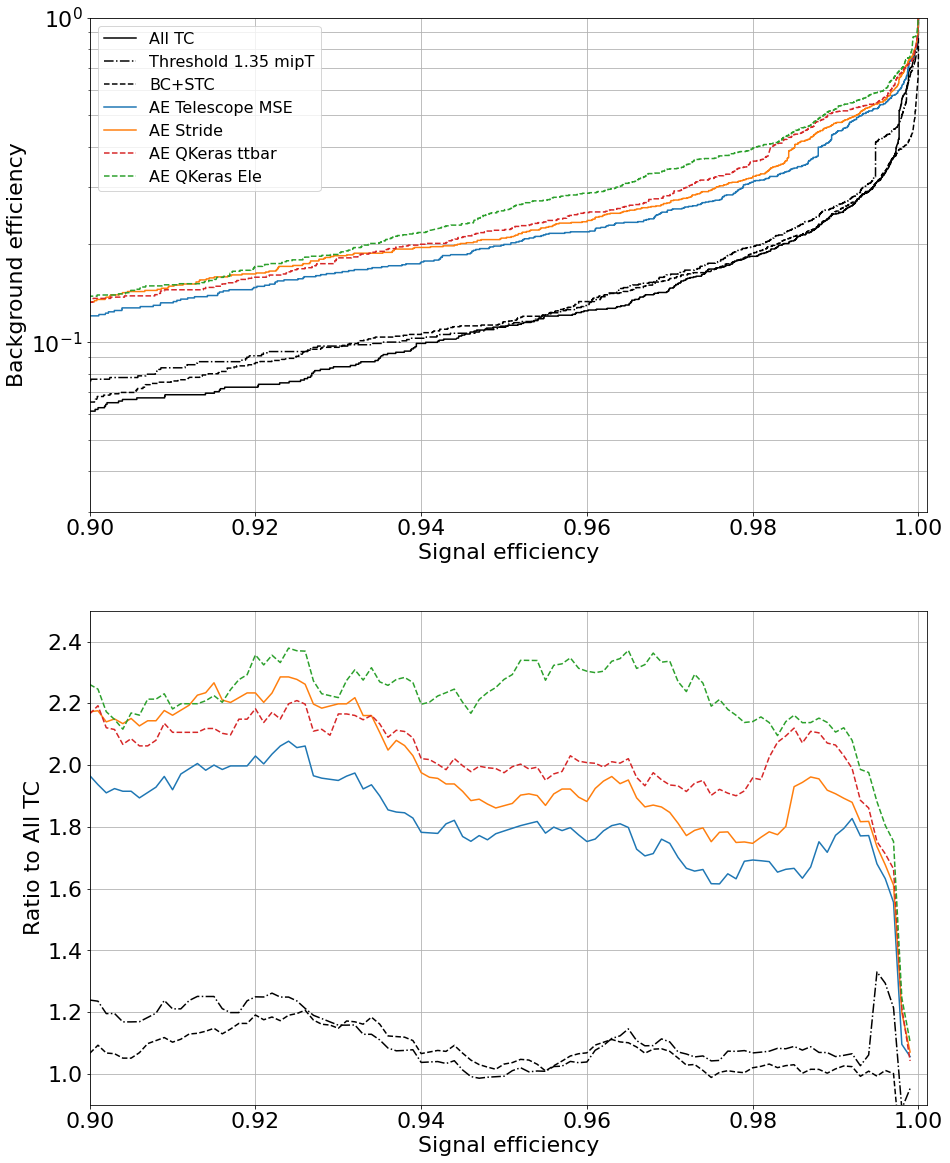

In [14]:
#build ROC
tpr_ratio = np.arange(0.9, 1.0, 0.001)
matplotlib.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(2, 1, figsize=(15,20))
fpr_ref = fprs['extended'][ref_name]
tpr_ref = tprs['extended'][ref_name]
for name in plotted_algo:
    ## New inputs
    fpr = fprs['extended'][name]
    tpr = tprs['extended'][name]
    roc_auc = metrics.auc(fpr, tpr)    
    axs[0].plot(tpr,fpr, label = legends[name],
                c=colors[name], ls=styles[name])
    if name!=ref_name:
        ratio = np.interp(tpr_ratio, tpr, fpr) / np.interp(tpr_ratio, tpr_ref, fpr_ref)
        axs[1].plot(tpr_ratio,ratio, c=colors[name], ls=styles[name])
axs[0].legend(loc = 'upper left', fontsize=16)
axs[0].grid(which='both')
axs[0].set_xlim(0.9,1.001)
axs[0].set_yscale('log')
axs[0].set_ylim(0.03,1)
axs[0].set_xlabel('Signal efficiency')
axs[0].set_ylabel('Background efficiency') 

axs[1].grid(which='both')
axs[1].set_xlim(0.9,1.001)
axs[1].set_ylim(0.9,2.5)
axs[1].set_xlabel('Signal efficiency')
axs[1].set_ylabel('Ratio to All TC')

plt.show()

### PU clusters per event vs signal efficiency
Although this plot is better than ROC curves for comparison since the number of PU clusters is normalized per event, the curves still cannot be directly compared because the initial population of PU clusters still differ between FE options. 

This is due to the fact that the energy scale is not necessarily flat vs pT, and the 20GeV selection cut applied on the corrected pT doesn't have the same effect for all the different FE options. Algorithms with a lower energy scale around 20GeV will have artificially better performance because of less low pT clusters promoted above the 20GeV cut.

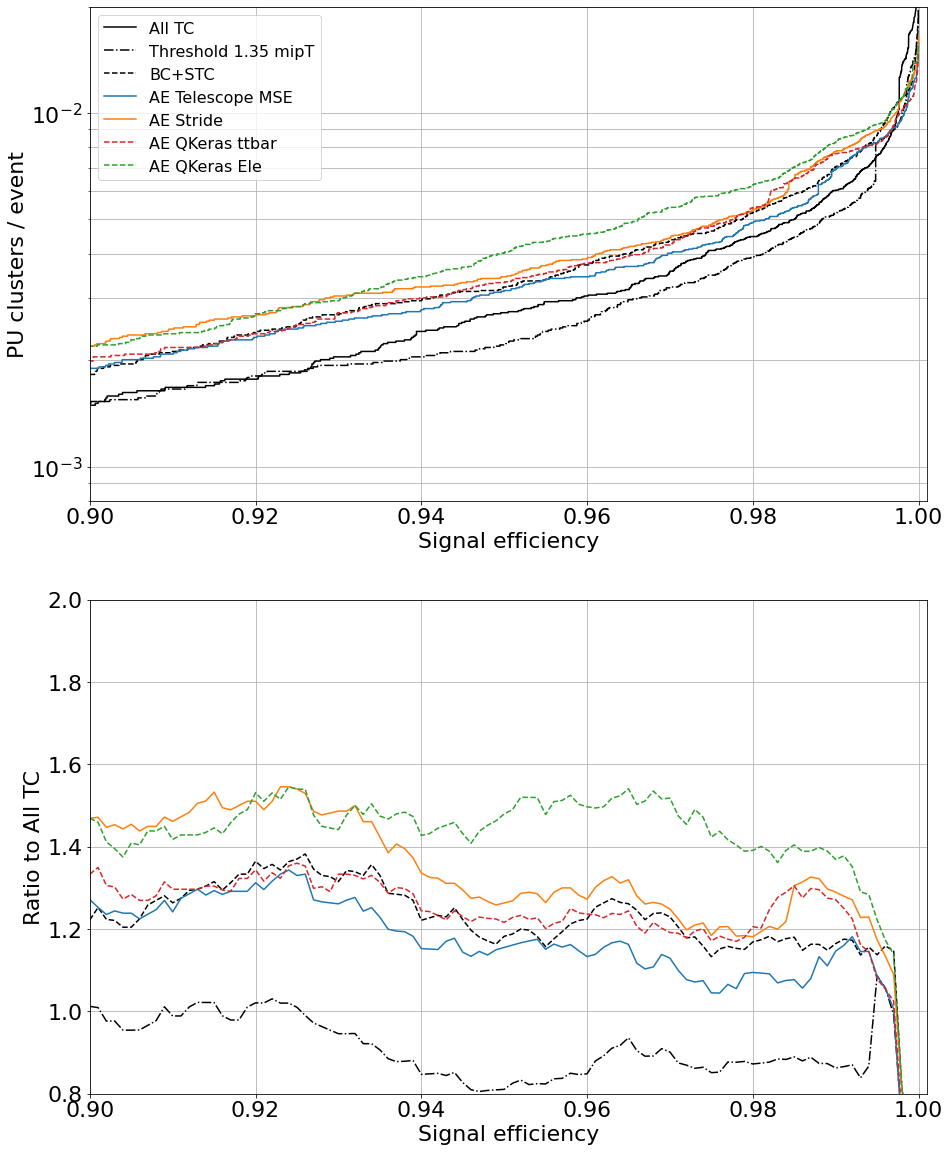

In [15]:
tpr_ratio = np.arange(0.9, 1.0, 0.001)
matplotlib.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(2, 1, figsize=(15,20))
fpr_ref = fprs['extended'][ref_name]*nclusters_per_event[ref_name]
tpr_ref = tprs['extended'][ref_name]
for name in plotted_algo:
    ## New inputs
    fpr = fprs['extended'][name]*nclusters_per_event[name]
    tpr = tprs['extended'][name]
    roc_auc = metrics.auc(fpr, tpr)    
    axs[0].plot(tpr,fpr, label = legends[name],
                c=colors[name], ls=styles[name])
    if name!=ref_name:
        ratio = np.interp(tpr_ratio, tpr, fpr) / np.interp(tpr_ratio, tpr_ref, fpr_ref)
        axs[1].plot(tpr_ratio,ratio, c=colors[name], ls=styles[name])
axs[0].legend(loc = 'upper left', fontsize=16)
axs[0].grid(which='both')
axs[0].set_xlim(0.9,1.001)
axs[0].set_yscale('log')
axs[0].set_ylim(0.0008,0.02)
axs[0].set_xlabel('Signal efficiency')
axs[0].set_ylabel('PU clusters / event') 

axs[1].grid(which='both')
axs[1].set_xlim(0.9,1.001)
axs[1].set_ylim(0.8,2)
axs[1].set_xlabel('Signal efficiency')
axs[1].set_ylabel('Ratio to All TC')

plt.show()

## Checking signal efficiencies

Extracting electrons from the full dataframe and defining eta and pT bins (gen particle level). Eta bins are 0.1 units wide, and pT bins are 5 GeV wide.

In [16]:
dfs_ele = {}
for name,df in algos_dfs.items():
    df_ele = df[df.genpart_pid==1]
    df_ele['genpart_abseta'] = np.abs(df_ele.genpart_exeta)
    df_ele['genpart_bineta'] = ((df_ele.genpart_abseta - etamin)/0.1).astype('int32')
    df_ele['genpart_binpt'] = ((df_ele.genpart_pt - ptmin)/5).astype('int32')
    dfs_ele[name] = df_ele

<ipython-input-16-6f350050679c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ele['genpart_abseta'] = np.abs(df_ele.genpart_exeta)
<ipython-input-16-6f350050679c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ele['genpart_bineta'] = ((df_ele.genpart_abseta - etamin)/0.1).astype('int32')
<ipython-input-16-6f350050679c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Extracting BDT output cuts that provide a 99% signal efficiency inclusively.

In [17]:
bdt_thresholds = {}
for name, threshold in thresholds['extended'].items():
    tpr = tprs['extended'][name]
    bdt_thresholds[name] = np.interp(0.99, tpr, threshold)
    print(name, bdt_thresholds[name])

Threshold0 0.17797108769416814
Threshold 0.18390470233228473
Mixedbcstc 0.18640350107635764
AutoEncoderTelescopeMSE 0.20372799053788185
AutoEncoderStride 0.20495414435863502
AutoEncoderQKerasTTbar 0.20554066941142082
AutoEncoderQKerasEle 0.18646449148654945


In [18]:
def efficiency(group, cut):
    tot = group.shape[0]
    sel = group[group.bdt_output > cut].shape[0]
    return sel/tot

### Efficiency vs eta

In [19]:
efficiencies_vs_eta = {}
for name,df in dfs_ele.items():
    full = xgb.DMatrix(data=df[inputs['extended']], label=df[output], feature_names=inputs['extended'])
    df['bdt_output'] = boosters['extended'][name].predict(full)
    efficiencies_vs_eta[name] = df.groupby('genpart_bineta').mean()
    efficiencies_vs_eta[name]['efficiency'] = df.groupby('genpart_bineta').apply(lambda x : efficiency(x, bdt_thresholds[name]))

<ipython-input-19-214a33025ca4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bdt_output'] = boosters['extended'][name].predict(full)
<ipython-input-19-214a33025ca4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bdt_output'] = boosters['extended'][name].predict(full)
<ipython-input-19-214a33025ca4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

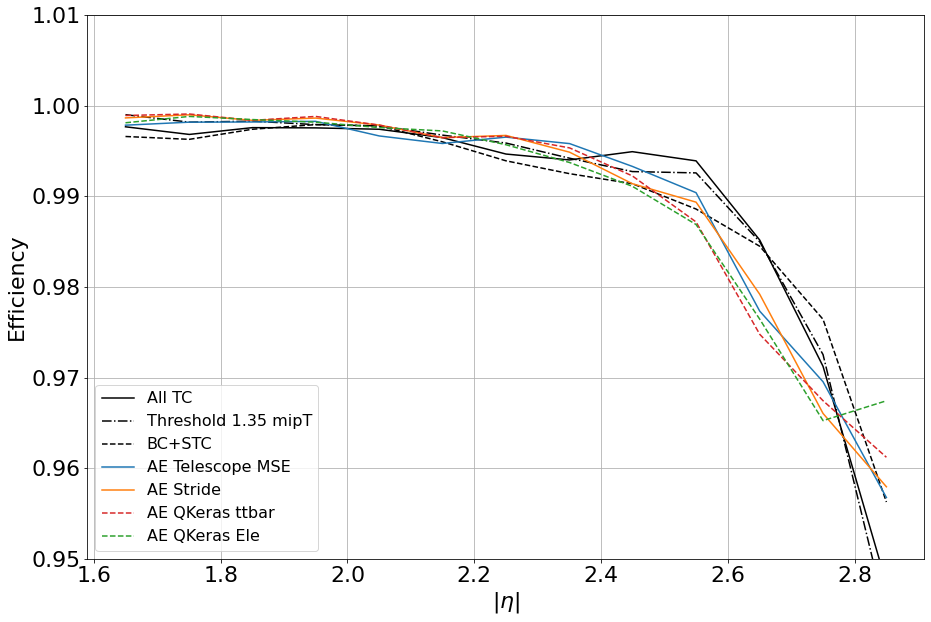

In [20]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = efficiencies_vs_eta[name]
    plt.plot(df.genpart_abseta, df.efficiency, 
             label=legends[name], color=colors[name], ls=styles[name])
plt.ylim(0.95, 1.01)
plt.legend(loc = 'lower left', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel('Efficiency')
plt.grid()
plt.show()

### Efficiency vs pT

In [21]:
efficiencies_vs_pt = {}
for name,df in dfs_ele.items():
    full = xgb.DMatrix(data=df[inputs['extended']], label=df[output], feature_names=inputs['extended'])
    df['bdt_output'] = boosters['extended'][name].predict(full)
    efficiencies_vs_pt[name] = df.groupby('genpart_binpt').mean()
    efficiencies_vs_pt[name]['efficiency'] = df.groupby('genpart_binpt').apply(lambda x : efficiency(x, bdt_thresholds[name]))

<ipython-input-21-e8d0a7c9eff6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bdt_output'] = boosters['extended'][name].predict(full)
<ipython-input-21-e8d0a7c9eff6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bdt_output'] = boosters['extended'][name].predict(full)
<ipython-input-21-e8d0a7c9eff6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

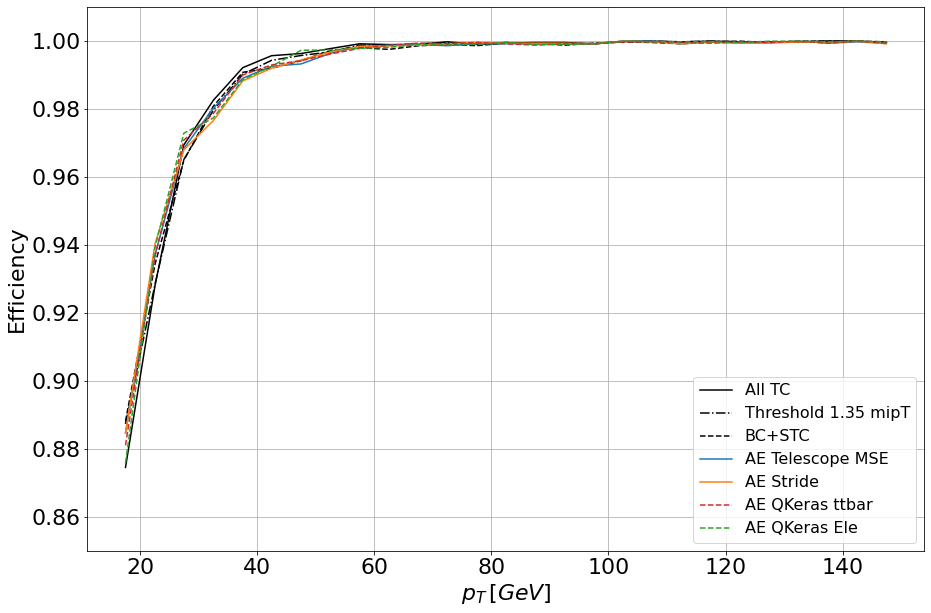

In [22]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = efficiencies_vs_pt[name]
    plt.plot(df.genpart_pt, df.efficiency, 
             label=legends[name], color=colors[name], ls=styles[name])
plt.ylim(0.85, 1.01)
plt.legend(loc = 'lower right', fontsize=16)
plt.xlabel(r'$p_{T}\,[GeV]$')
plt.ylabel('Efficiency')
plt.grid()
plt.show()

## Storing BDTs for external use
Stores as well ROC curves (TPR, FPR, thresholds)

In [23]:
with open('data/xgboost_electron_pu_autoencoder_{}.pkl'.format(version), 'wb') as f:
    pickle.dump(boosters, f)
with open('data/xgboost_fpr_electron_pu_autoencoder_{}.pkl'.format(version), 'wb') as f:
    pickle.dump(fprs, f)
with open('data/xgboost_tpr_electron_pu_autoencoder_{}.pkl'.format(version), 'wb') as f:
    pickle.dump(tprs, f)
with open('data/xgboost_threshold_electron_pu_autoencoder_{}.pkl'.format(version), 'wb') as f:
    pickle.dump(thresholds, f)